In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/Shareddrives/LASER_on_Luhya")

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [ ]:
!pip install laserembeddings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 4.1 MB/s 
     |████████████████████████████████| 859 kB 47.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-py3-none-any.whl size=883989 sha256=da27c8e9ad2bd57d65110a7b6553d6e18de5a67aaa26f1bc0ee033496cc62c54
  Stored in directory: /root/.cache/pip/wheels/d1/ff/0e/e00ff1e22100702ac8b24e709551ae0fb29db9ffc843510a64
Successfully built sacremoses


In [ ]:
! python -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [ ]:
# Experiment summary
import pandas as pd

# experiment = {'Language': ['Luhya','Luhya','Luhya','Luhya','Swahili','Swahili','Swahili','Swahili'],
#               'Measure':['Cosine Similarity','Cosine Similarity','kNN','kNN','Cosine Similarity','Cosine Similarity','kNN','kNN'],
#               'Direction':['en->luh','luh->en','en->luh','luh->en','en->sw','sw->en','en->sw','sw->en'],
#               'Accuracy':[0,0,0,0,0,0,0,0],
#               'F1 Score':[0,0,0,0,0,0,0,0]}

experiment = {'Language': ['Luhya','Luhya','Swahili','Swahili'],
              'Measure':['Cosine Similarity','kNN','Cosine Similarity','kNN'],
              'Direction':['en->luh','en->luh','en->sw','en->sw'],
              'Accuracy':[0,0,0,0],
              'F1 Score':[0,0,0,0]}

df_results = pd.DataFrame(experiment)

def results(mes, direction, accurate, ngold):
  index_val = df_results.loc[(df_results['Measure']==mes) & (df_results['Direction']==direction)].index

  df_results.loc[index_val, 'Accuracy'] = (accurate/ngold)
  precision = recall = (accurate/ngold)
  df_results.loc[index_val, 'F1 Score'] = (2*precision*recall)/(precision+recall)

  return df_results

# Trial on Luhya using Laser embedding

In [ ]:
from laserembeddings import Laser

laser = Laser()

# if all sentences are in the same language:

embeddings = laser.embed_sentences(
    ['let your neural network be polyglot',
     'use multilingual embeddings!'],
    lang='en') 

In [ ]:
df = pd.read_csv('Luhya.csv')

In [ ]:
df.head()

,target_sentence,source_sentence
0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th..."
1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ..."
2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b..."
3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ..."
4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b..."


In [ ]:
df.shape

(7952, 2)

In [ ]:
# english_embeddings = laser.embed_sentences(
#     df['source_sentence'].values,
#     lang='en')

# luhya_embeddings = laser.embed_sentences(
#     df['target_sentence'].values,
#     lang='luy')

In [ ]:
luhya_embeddings = np.loadtxt('luh_en_embeddings.csv', delimiter=',')
english_embeddings = np.loadtxt('luh_luh_embeddings.csv', delimiter=',')

c1 = np.loadtxt('scipyen_luh.csv', delimiter=',')

In [ ]:
english_embeddings.shape

(7952, 1024)

In [ ]:
luhya_embeddings.shape

(7952, 1024)

In [ ]:
similarity_index1=cosine_similarity(english_embeddings,luhya_embeddings)
similarity_index2=cosine_similarity(luhya_embeddings, english_embeddings)

print(df['source_sentence'].values[0])

The book of the genealogy of Jesus Christ , the Son of David , the Son of Abraham :


In [ ]:
similarity_index1.shape

(7952, 7952)

In [ ]:
similarity_index2.shape

(7952, 7952)

In [ ]:
np.allclose(similarity_index1, similarity_index2.T)

True

In [ ]:
np.array_equal(similarity_index1, similarity_index2.T)

False

In [ ]:
c1 = np.zeros(similarity_index1.shape)
c2 = np.zeros(similarity_index1.shape)

for i in range(similarity_index1.shape[0]):
  for j in range(similarity_index1.shape[0]):
    c1[i][j]=1 - cosine(english_embeddings[i],luhya_embeddings[j])
    c2[i][j]=1 - cosine(luhya_embeddings[i], english_embeddings[j])

In [ ]:
np.allclose(c1, c2.T)

True

In [ ]:
np.array_equal(c1, c2.T)

True

In [ ]:
# Saving the arrays
np.savetxt('luh_en_embeddings.csv', english_embeddings, delimiter=',')
np.savetxt('luh_luh_embeddings.csv', luhya_embeddings, delimiter=',')

np.savetxt('scipyen_luh.csv', c1, delimiter=',')
np.savetxt('scipyluh_en.csv', c2, delimiter=',')

np.savetxt('sklearnen_luh.csv', similarity_index1, delimiter=',')
np.savetxt('sklearnluh_en.csv', similarity_index2, delimiter=',')

In [ ]:
aligned = np.argmax(c1, axis=1)

In [ ]:
df = df.reset_index()
df.head()

,index,target_sentence,source_sentence
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th..."
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ..."
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b..."
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ..."
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b..."


In [ ]:
df['aligned'] = aligned
df.head()

,index,target_sentence,source_sentence,aligned
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th...",3659
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ...",200
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b...",4208
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ...",7092
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b...",2074


In [ ]:
accurate = df[df['index']==df['aligned']]

In [ ]:
accurate.shape

(121, 4)

In [ ]:
accurate

,index,target_sentence,source_sentence,aligned
15,15,Yakobo yali samwana Yosefu omusaatsa wa Mariam...,"And Jacob begot Joseph the husband of Mary , o...",15
27,27,"Ne lwomuruchi Herode , halala nende abandu boo...","When Herod the king heard this , he was troubl...",27
30,30,"‘ Nawe Betselehemu , mushialo shia Yuda shioli...","‘ But you , Bethlehem , in the land of Judah ,...",30
82,82,Olwa Yesu yali nachendanga khuluchinga lweinya...,"And Jesus , walking by the Sea of Galilee , sa...",82
449,449,"Uno shiniye omwana owomubaatsi ? , Nyina shial...",Is this not the carpenter ’ s son ? Is not His...,449
...,...,...,...,...
6850,6850,Musa yali omusuubilwa munzu eya Nyasaye shinga...,And Moses indeed was faithful in all His house...,6850
7059,7059,"Balaswa namachina , nibarasibwa mubitonye bibi...","They were stoned , they were sawn in two , wer...",7059
7146,7146,"nenywe , nimwakhamuhelesia oluyali olunji owif...",and you pay attention to the one wearing the f...,7146
7157,7157,Abaana befwe nibukhala shiina omundu niyakhabo...,"What does it profit , my brethren , if someone...",7157


In [ ]:
results('Cosine Similarity', 'en->luh', accurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.000000,0.000000
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
d1 = np.zeros(c1.shape)

for i in range(c1.shape[0]):
  for j in range(c1.shape[0]):
    d1[i][j]=norm(english_embeddings[i]-luhya_embeddings[j])

In [ ]:
np.savetxt('knnen_luh.csv', d1, delimiter=',')

In [ ]:
daligned = np.argmin(d1, axis=1)
df['daligned'] = daligned

In [ ]:
daccurate = df[df['index']==df['daligned']]
daccurate.shape

(17, 5)

In [ ]:
results('kNN', 'en->luh', daccurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.002138,0.002138
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


# Trial on Swahili using Laser embedding

In [ ]:
df = pd.read_csv('swahilibible.csv')

In [ ]:
df.head()

,source_sentence,target_sentence
0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
df = df.head(10000)

In [ ]:
df.shape

(10000, 2)

In [ ]:
df.head()

,source_sentence,target_sentence
0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
en_embeddings = laser.embed_sentences(
    df['source_sentence'].values,
    lang='en')

sw_embeddings = laser.embed_sentences(
    df['target_sentence'].values,
    lang='sw')

In [ ]:
en_embeddings.shape

(10000, 1024)

In [ ]:
sw_embeddings.shape

(10000, 1024)

In [ ]:
similarity_index1=cosine_similarity(en_embeddings,sw_embeddings)

In [ ]:
d1 = np.zeros(similarity_index1.shape)

for i in range(similarity_index1.shape[0]):
  for j in range(similarity_index1.shape[0]):
    d1[i][j]=norm(en_embeddings[i]-sw_embeddings[j])

In [ ]:
# Saving the arrays
np.savetxt('sw_en_embeddings.csv', en_embeddings, delimiter=',')
np.savetxt('sw_sw_embeddings.csv', sw_embeddings, delimiter=',')

np.savetxt('sklearnen_sw.csv', similarity_index1, delimiter=',')
np.savetxt('knnen_sw.csv', d1, delimiter=',')

In [ ]:
aligned = np.argmax(similarity_index1, axis=1)

In [ ]:
aligned

array([3060, 3981,    2, ..., 9997, 9998, 4586])

In [ ]:
df = df.reset_index()
df.head()

,index,source_sentence,target_sentence
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
df['aligned'] = aligned
df.head()

,index,source_sentence,target_sentence,aligned
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...,3060
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...,3981
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...,2
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ...",2206
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...,4


In [ ]:
accurate = df[df['index']==df['aligned']]

In [ ]:
accurate.shape

(4957, 4)

In [ ]:
results('Cosine Similarity', 'en->sw', accurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.002138,0.002138
2,Swahili,Cosine Similarity,en->sw,0.495700,0.495700
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
aligned2 = np.argmin(d1, axis=0)
df['aligned2'] = aligned2
df[df['index']==df['aligned2']].shape

(4476, 5)

In [ ]:
daccurate = df[df['index']==df['aligned2']].shape

In [ ]:
results('kNN', 'en->sw', daccurate[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.002138,0.002138
2,Swahili,Cosine Similarity,en->sw,0.495700,0.495700
3,Swahili,kNN,en->sw,0.447600,0.447600


## Results

In [ ]:
results('kNN', 'en->luh', daccurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.002138,0.002138
2,Swahili,Cosine Similarity,en->sw,0.617000,0.617000
3,Swahili,kNN,en->sw,0.551300,0.551300


# LaBSE

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 4.4 MB 46.5 MB/s 
     |████████████████████████████████| 1.2 MB 62.0 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
     |████████████████████████████████| 596 kB 68.1 MB/s 
     |████████████████████████████████| 6.6 MB 8.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b946dd4b82a74474eb76e1cb9a49b66a68e82eab2a197b90f903e5a28f7a35cd
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(sentences)
print(embeddings)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

[[ 0.02882474 -0.00602381 -0.05947005 ... -0.03002252 -0.02960698
   0.00067479]
 [-0.05550232  0.02546486 -0.02157255 ...  0.02932104  0.01150041
  -0.00848788]]


## Luhya

In [ ]:
# Experiment summary
import pandas as pd

experiment = {'Language': ['Luhya','Luhya','Swahili','Swahili'],
              'Measure':['Cosine Similarity','kNN','Cosine Similarity','kNN'],
              'Direction':['en->luh','en->luh','en->sw','en->sw'],
              'Accuracy':[0,0,0,0],
              'F1 Score':[0,0,0,0]}

df_results = pd.DataFrame(experiment)

def results(mes, direction, accurate, ngold):
  index_val = df_results.loc[(df_results['Measure']==mes) & (df_results['Direction']==direction)].index

  df_results.loc[index_val, 'Accuracy'] = (accurate/ngold)
  precision = recall = (accurate/ngold)
  df_results.loc[index_val, 'F1 Score'] = (2*precision*recall)/(precision+recall)

  return df_results

In [ ]:
import numpy as np
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [ ]:
df = pd.read_csv('Luhya.csv')

In [ ]:
df.head(1)

,target_sentence,source_sentence
0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th..."


In [ ]:
lh = df['target_sentence'].values.tolist()
en = df['source_sentence'].values.tolist()
print(len(lh),len(en))

7952 7952


'Tsino nitsio tsinzibulo tsiabakuukanyene Yesu Kristo owomulwibulo lwa Daudi , owali womulwibulo lwa , Aburahamu .'

In [ ]:
lh_embeddings = model.encode(lh)
en_embeddings = model.encode(en)

In [ ]:
len(embeddings[0])

768

In [ ]:
lh_embed = np.array(lh_embeddings)
en_embed = np.array(en_embeddings)

In [ ]:
en_embed.shape

(7952, 768)

In [ ]:
sim=cosine_similarity(en_embed,lh_embed)

In [ ]:
aligned = np.argmax(sim, axis=1)

In [ ]:
df = df.reset_index()
df.head()

,index,target_sentence,source_sentence
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th..."
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ..."
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b..."
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ..."
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b..."


In [ ]:
df['aligned'] = aligned
df.head()

,index,target_sentence,source_sentence,aligned
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th...",0
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ...",1
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b...",2
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ...",3
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b...",4


In [ ]:
accurate = df[df['index']==df['aligned']]

In [ ]:
results('Cosine Similarity', 'en->luh', accurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.219945,0.219945
1,Luhya,kNN,en->luh,0.000000,0.000000
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
d1 = np.zeros(sim.shape)

for i in range(sim.shape[0]):
  for j in range(sim.shape[0]):
    d1[i][j]=norm(en_embed[i]-lh_embed[j])

In [ ]:
daligned = np.argmin(d1, axis=1)
df['daligned'] = daligned

In [ ]:
daccurate = df[df['index']==df['daligned']]
daccurate.shape

(1749, 5)

In [ ]:
results('kNN', 'en->luh', daccurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.219945,0.219945
1,Luhya,kNN,en->luh,0.219945,0.219945
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


## Swahili

In [ ]:
df = pd.read_csv('swahilibible.csv')

In [ ]:
df.head()

,source_sentence,target_sentence
0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
df = df.head(10000)

In [ ]:
df.shape

(10000, 2)

In [ ]:
df.head()

,source_sentence,target_sentence
0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
sw = df['target_sentence'].values.tolist()
en = df['source_sentence'].values.tolist()
print(len(sw),len(en))

10000 10000


In [ ]:
sw_embeddings = model.encode(sw)
en_embeddings = model.encode(en)

In [ ]:
sw_embed = np.array(sw_embeddings)
en_embed = np.array(en_embeddings)

In [ ]:
similarity_index1=cosine_similarity(en_embed,sw_embed)

In [ ]:
d1 = np.zeros(similarity_index1.shape)

for i in range(similarity_index1.shape[0]):
  for j in range(similarity_index1.shape[0]):
    d1[i][j]=norm(en_embed[i]-sw_embed[j])

In [ ]:
aligned = np.argmax(similarity_index1, axis=1)

In [ ]:
df = df.reset_index()
df.head()

,index,source_sentence,target_sentence
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
df['aligned'] = aligned
df.head()

,index,source_sentence,target_sentence,aligned
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...,0
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...,1
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...,2
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ...",3
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...,4


In [ ]:
accurate = df[df['index']==df['aligned']]

In [ ]:
accurate.shape

(9714, 4)

In [ ]:
results('Cosine Similarity', 'en->sw', accurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.219945,0.219945
1,Luhya,kNN,en->luh,0.219945,0.219945
2,Swahili,Cosine Similarity,en->sw,0.971400,0.971400
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
aligned2 = np.argmin(d1, axis=0)
df['aligned2'] = aligned2
df[df['index']==df['aligned2']].shape

(9708, 5)

In [ ]:
daccurate = df[df['index']==df['aligned2']].shape

In [ ]:
results('kNN', 'en->sw', daccurate[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.219945,0.219945
1,Luhya,kNN,en->luh,0.219945,0.219945
2,Swahili,Cosine Similarity,en->sw,0.971400,0.971400
3,Swahili,kNN,en->sw,0.970800,0.970800


# Finetuning

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

In [ ]:
#!wget -c https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
#!tar xvzf aclImdb_v1.tar.gz

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 #8 #16
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                            batch_size=batch_size,
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                             batch_size=batch_size)

Found 75000 files belonging to 3 classes.
Using 60000 files for training.
Found 75000 files belonging to 3 classes.
Using 15000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
tfhub_handle_preprocess="https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"
tfhub_handle_encoder="https://tfhub.dev/google/LaBSE/2"

In [ ]:
def build_classifier_model():
 text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
 preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
 encoder_inputs = preprocessing_layer(text_input)
 encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='LaBSE_encoder')
 outputs = encoder(encoder_inputs)
 net = outputs['pooled_output']
 net = tf.keras.layers.Dropout(0.1)(net)
 net = tf.keras.layers.Dense(1, name='classifier')(net)
 return tf.keras.Model(text_input, net)

In [ ]:
from tensorflow_addons.optimizers import AdamW

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([1000], [5e-5,1e-5])
lr = 1 * schedule(step)
wd = lambda: 1e-6 * schedule(step)
optimizer=AdamW(learning_rate=lr,weight_decay=wd)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         optimizer=optimizer,
                         metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

history = classifier_model.fit(train_ds,validation_data=val_ds,
                               epochs=1, batch_size=32)

# Top-1 results

**LASER results on Religious data**

In [ ]:
#@title
results('kNN', 'en->sw', daccurate[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.002138,0.002138
2,Swahili,Cosine Similarity,en->sw,0.495700,0.495700
3,Swahili,kNN,en->sw,0.447600,0.447600


**LaBSE results on Religious data**

In [ ]:
results('kNN', 'en->sw', daccurate[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.219945,0.219945
1,Luhya,kNN,en->luh,0.219945,0.219945
2,Swahili,Cosine Similarity,en->sw,0.971400,0.971400
3,Swahili,kNN,en->sw,0.970800,0.970800


# Top -3 results

## LASER

### Luhya

In [ ]:
df = pd.read_csv('Luhya.csv')

In [ ]:
luhya_embeddings = np.loadtxt('luh_en_embeddings.csv', delimiter=',')
english_embeddings = np.loadtxt('luh_luh_embeddings.csv', delimiter=',')

c1 = np.loadtxt('scipyen_luh.csv', delimiter=',')

In [ ]:
sim = np.loadtxt('scipyen_luh.csv', delimiter=',')

In [ ]:
def top_3(a, n):
  top3 = []

  for i in range(a.shape[0]):
    x = np.argsort(a[i])[::-1][:n]
    top3.append(x)

  return top3

In [ ]:
aligned = top_3(c1, 3)

In [ ]:
df = df.reset_index()
df.head()

,index,target_sentence,source_sentence
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th..."
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ..."
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b..."
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ..."
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b..."


In [ ]:
df.columns = ['id','target_sentence','source_sentence']

In [ ]:
df['aligned'] = aligned
df.head()

,id,target_sentence,source_sentence,aligned
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th...","[3659, 1067, 7452]"
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ...","[200, 2204, 3348]"
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b...","[4208, 2204, 1824]"
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ...","[7092, 6194, 2352]"
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b...","[2074, 3434, 6452]"


In [ ]:
df['accurate'] = df.apply(lambda row: row.id in row.aligned, axis = 1)

In [ ]:
accurate = df[df['accurate']==True]

In [ ]:
results('Cosine Similarity', 'en->luh', accurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.024145,0.024145
1,Luhya,kNN,en->luh,0.000000,0.000000
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
d1 = np.loadtxt('knnen_luh.csv', delimiter=',')

In [ ]:
def bottom_3(a, n):
  top3 = []

  for i in range(a.shape[0]):
    x = np.argsort(a[i])[::-1][-n:]
    top3.append(x)

  return top3

In [ ]:
daligned = bottom_3(d1, 3)

In [ ]:
df['daligned'] = daligned

In [ ]:
df['daccurate'] = df.apply(lambda row: row.id in row.daligned, axis = 1)

In [ ]:
daccurate = df[df['daccurate']==True]

In [ ]:
results('kNN', 'en->luh', daccurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.024145,0.024145
1,Luhya,kNN,en->luh,0.005659,0.005659
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
t = np.linspace(c1.min(), c1.max(),22)[:-2]
d = np.argmax(c1, axis=1)

In [ ]:
s_c = np.max(c1,axis=1)

In [ ]:
print(t,d,s_c)

[-0.0657146  -0.01807975  0.02955509  0.07718994  0.12482479  0.17245963
  0.22009448  0.26772932  0.31536417  0.36299901  0.41063386  0.4582687
  0.50590355  0.5535384   0.60117324  0.64880809  0.69644293  0.74407778
  0.79171262  0.83934747] [3659  200 4208 ... 1451 4063 5650] [0.74120855 0.79948652 0.83037084 ... 0.58009064 0.70437783 0.74234813]


In [ ]:
acc = []
for i in t:
  ts = np.argwhere(s_c >= i)
  count = 0
  for j in ts:
    if j[0]==d[j[0]]:
      count+=1
  print(ts.shape[0],' above ',i,' with ',count,'correct.')
  acc.append(count/ts.shape[0])
print(acc)

7952  above  -0.06571459770202637  with  121 correct.
7952  above  -0.01807975201379685  with  121 correct.
7952  above  0.029555093674432667  with  121 correct.
7952  above  0.07718993936266219  with  121 correct.
7952  above  0.1248247850508917  with  121 correct.
7952  above  0.1724596307391212  with  121 correct.
7952  above  0.22009447642735075  with  121 correct.
7950  above  0.26772932211558026  with  121 correct.
7946  above  0.31536416780380977  with  121 correct.
7912  above  0.3629990134920393  with  121 correct.
7849  above  0.4106338591802688  with  121 correct.
7695  above  0.45826870486849836  with  121 correct.
7401  above  0.5059035505567279  with  121 correct.
6892  above  0.5535383962449574  with  121 correct.
6043  above  0.6011732419331869  with  120 correct.
4673  above  0.6488080876214164  with  112 correct.
2825  above  0.6964429333096459  with  88 correct.
1310  above  0.7440777789978754  with  49 correct.
600  above  0.7917126246861049  with  20 correct.
185  

In [ ]:
len(acc)

20

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2,rc = {'figure.figsize':(15,10)})

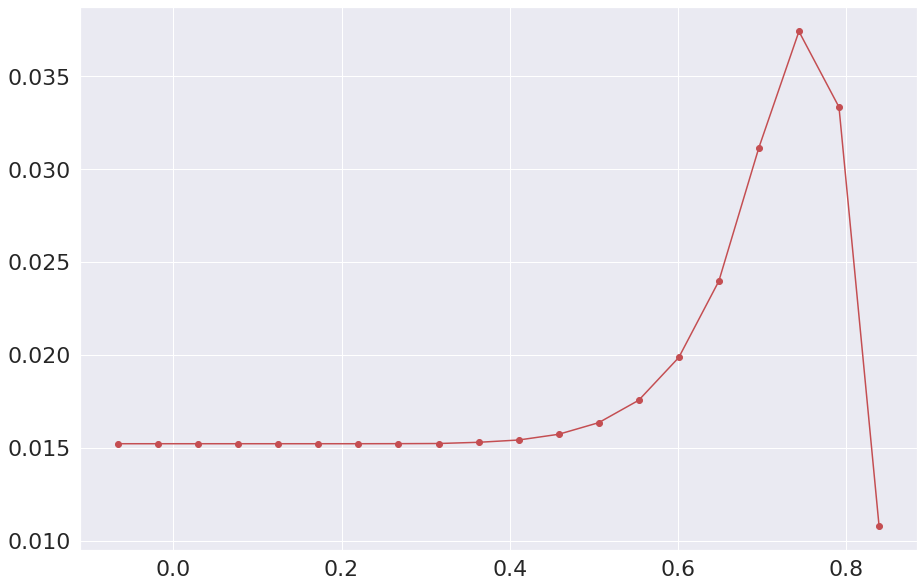

In [ ]:
plt.plot(t,acc,marker='o', color='r')

In [ ]:
lh = df['target_sentence'].values.tolist()
en = df['source_sentence'].values.tolist()
print(len(lh),len(en))

7952 7952


In [ ]:
lh_embeddings = model.encode(lh)
en_embeddings = model.encode(en)

In [ ]:
sim=cosine_similarity(en_embeddings,lh_embeddings)

In [ ]:
t2 = np.linspace(sim.min(), sim.max(),22)[:-2]
d2 = np.argmax(sim, axis=1)

In [ ]:
s_c2 = np.max(c1,axis=1)

In [ ]:
print(t2,d2,s_c2)

[-0.34723306 -0.28705154 -0.22687001 -0.16668849 -0.10650697 -0.04632545
  0.01385607  0.07403759  0.13421911  0.19440063  0.25458216  0.31476368
  0.3749452   0.43512672  0.49530824  0.55548976  0.61567128  0.6758528
  0.73603433  0.79621585] [   0    1    2 ... 7397 7950 5210] [0.74120855 0.79948652 0.83037084 ... 0.58009064 0.70437783 0.74234813]


In [ ]:
acc2 = []
for i in t2:
  ts = np.argwhere(s_c2>= i)
  count = 0
  for j in ts:
    if j[0]==d2[j[0]]:
      count+=1
  print(ts.shape[0],' above ',i,' with ',count,'correct.')
  acc2.append(count/ts.shape[0])
print(acc2)

7952  above  -0.3472330570220947  with  1749 correct.
7952  above  -0.28705153578803655  with  1749 correct.
7952  above  -0.22687001455397832  with  1749 correct.
7952  above  -0.16668849331992014  with  1749 correct.
7952  above  -0.10650697208586193  with  1749 correct.
7952  above  -0.04632545085180373  with  1749 correct.
7952  above  0.013856070382254448  with  1749 correct.
7952  above  0.07403759161631268  with  1749 correct.
7952  above  0.13421911285037086  with  1749 correct.
7952  above  0.1944006340844291  with  1749 correct.
7952  above  0.25458215531848727  with  1749 correct.
7946  above  0.31476367655254545  with  1749 correct.
7902  above  0.3749451977866036  with  1741 correct.
7776  above  0.4351267190206618  with  1733 correct.
7479  above  0.4953082402547201  with  1695 correct.
6870  above  0.5554897614887783  with  1611 correct.
5696  above  0.6156712827228364  with  1467 correct.
3666  above  0.6758528039568947  with  1092 correct.
1513  above  0.73603432519095

In [ ]:
t2

array([-0.34723306, -0.28705154, -0.22687001, -0.16668849, -0.10650697,
       -0.04632545,  0.01385607,  0.07403759,  0.13421911,  0.19440063,
        0.25458216,  0.31476368,  0.3749452 ,  0.43512672,  0.49530824,
        0.55548976,  0.61567128,  0.6758528 ,  0.73603433,  0.79621585])

Text(0.5, 1.0, 'Accuracy vs Threshold for Luhya: LaBSE')

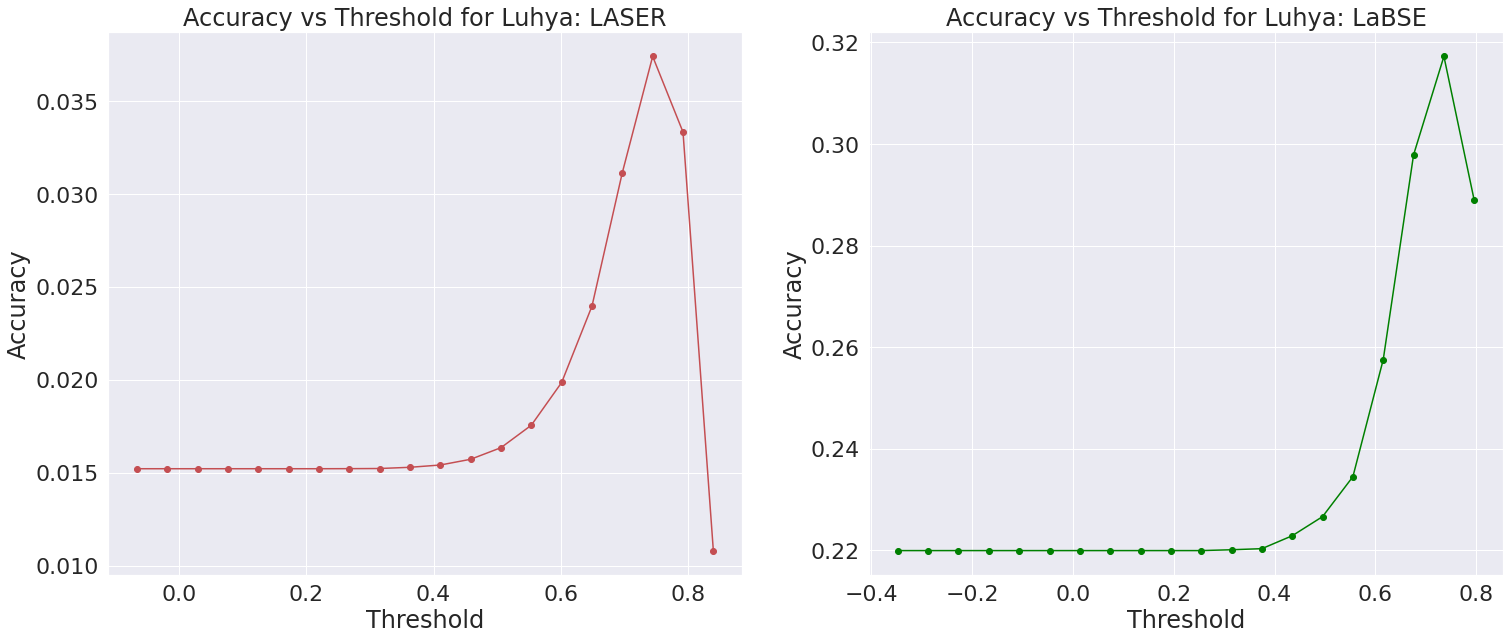

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25,10))
ax1.plot(t,acc,marker='o',color='r')
ax2.plot(t2,acc2,marker='o', color='green')

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Threshold')
ax1.set_title('Accuracy vs Threshold for Luhya: LASER')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Threshold')
ax2.set_title('Accuracy vs Threshold for Luhya: LaBSE')

In [ ]:
tt = np.linspace(cc1.min(), cc1.max(),22)[:-2]
dd = np.argmax(cc1, axis=1)

In [ ]:
tt

array([-0.00215747,  0.04519284,  0.09254315,  0.13989346,  0.18724376,
        0.23459407,  0.28194438,  0.32929469,  0.376645  ,  0.4239953 ,
        0.47134561,  0.51869592,  0.56604623,  0.61339654,  0.66074685,
        0.70809715,  0.75544746,  0.80279777,  0.85014808,  0.89749839])

In [ ]:
ss_c = np.max(cc1,axis=1)

In [ ]:
print(tt,dd,ss_c)

[-0.00215747  0.04519284  0.09254315  0.13989346  0.18724376  0.23459407
  0.28194438  0.32929469  0.376645    0.4239953   0.47134561  0.51869592
  0.56604623  0.61339654  0.66074685  0.70809715  0.75544746  0.80279777
  0.85014808  0.89749839] [3060 3981    2 ... 9997 9998 4586] [0.87477767 0.72916603 0.8089835  ... 0.93124187 0.90108812 0.77524066]


In [ ]:
sacc = []
for i in tt:
  ts = np.argwhere(ss_c >= i)
  count = 0
  for j in ts:
    if j[0]==dd[j[0]]:
      count+=1
  print(ts.shape[0],' above ',i,' with ',count,'correct.')
  sacc.append(count/ts.shape[0])
print(sacc)

10000  above  -0.0021574690472334623  with  4957 correct.
10000  above  0.04519283917865583  with  4957 correct.
10000  above  0.09254314740454513  with  4957 correct.
10000  above  0.13989345563043443  with  4957 correct.
10000  above  0.18724376385632371  with  4957 correct.
10000  above  0.234594072082213  with  4957 correct.
10000  above  0.2819443803081023  with  4957 correct.
10000  above  0.3292946885339916  with  4957 correct.
10000  above  0.3766449967598809  with  4957 correct.
10000  above  0.4239953049857702  with  4957 correct.
10000  above  0.47134561321165946  with  4957 correct.
9992  above  0.5186959214375487  with  4955 correct.
9957  above  0.5660462296634381  with  4948 correct.
9804  above  0.6133965378893274  with  4922 correct.
9421  above  0.6607468461152166  with  4856 correct.
8519  above  0.708097154341106  with  4707 correct.
7096  above  0.7554474625669952  with  4387 correct.
5511  above  0.8027977707928845  with  3821 correct.
3808  above  0.8501480790187

In [ ]:
tt2 = np.linspace(scc1.min(), scc1.max(),22)[:-2]
dd2 = np.argmax(scc1, axis=1)

In [ ]:
ss_c1 = np.max(scc1,axis=1)

In [ ]:
print(tt2,dd2,ss_c1)

[-0.27733058 -0.21822102 -0.15911147 -0.10000191 -0.04089236  0.01821719
  0.07732675  0.1364363   0.19554586  0.25465541  0.31376497  0.37287452
  0.43198408  0.49109363  0.55020318  0.60931274  0.66842229  0.72753185
  0.7866414   0.84575096] [   0    1    2 ... 9997 9998 9999] [0.92027414 0.827013   0.90110016 ... 0.79862    0.73893595 0.8234687 ]


In [ ]:
sacc2 = []
for i in tt2:
  ts = np.argwhere(ss_c1 >= i)
  count = 0
  for j in ts:
    if j[0]==dd2[j[0]]:
      count+=1
  print(ts.shape[0],' above ',i,' with ',count,'correct.')
  sacc2.append(count/ts.shape[0])
print(sacc2)

10000  above  -0.27733057737350464  with  9714 correct.
10000  above  -0.21822102296920048  with  9714 correct.
10000  above  -0.15911146856489636  with  9714 correct.
10000  above  -0.10000191416059223  with  9714 correct.
10000  above  -0.04089235975628808  with  9714 correct.
10000  above  0.018217194648016077  with  9714 correct.
10000  above  0.07732674905232018  with  9714 correct.
10000  above  0.13643630345662433  with  9714 correct.
10000  above  0.19554585786092848  with  9714 correct.
10000  above  0.2546554122652326  with  9714 correct.
10000  above  0.3137649666695368  with  9714 correct.
10000  above  0.3728745210738409  with  9714 correct.
9998  above  0.431984075478145  with  9714 correct.
9993  above  0.4910936298824492  with  9710 correct.
9981  above  0.5502031842867533  with  9699 correct.
9909  above  0.6093127386910575  with  9641 correct.
9725  above  0.6684222930953616  with  9470 correct.
9258  above  0.7275318474996657  with  9019 correct.
7949  above  0.78664

Text(0.5, 1.0, 'Accuracy vs Threshold for Swahili: LaBSE')

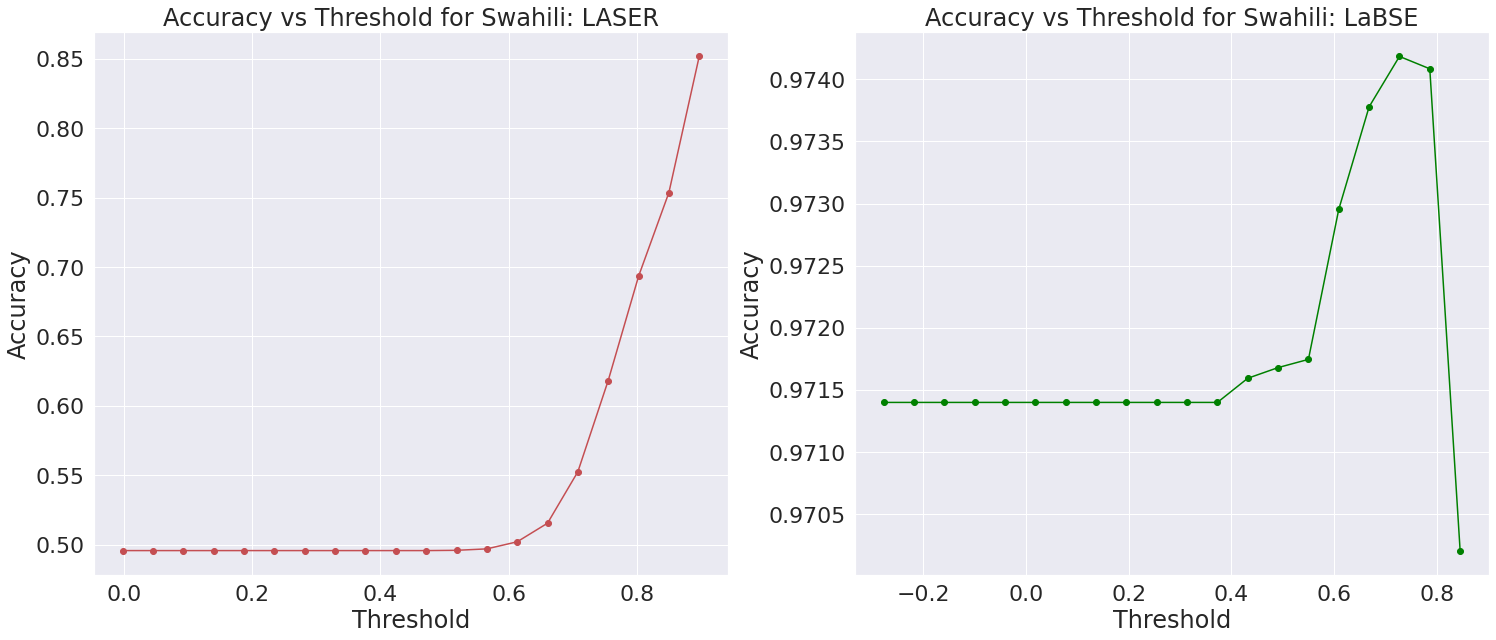

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25,10))
ax1.plot(tt,sacc,marker='o',color='r')
ax2.plot(tt2,sacc2,marker='o', color='green')

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Threshold')
ax1.set_title('Accuracy vs Threshold for Swahili: LASER')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Threshold')
ax2.set_title('Accuracy vs Threshold for Swahili: LaBSE')

### Swahili

In [ ]:
sw = pd.read_csv('swahilibible.csv')

In [ ]:
sw = sw.head(10000)

In [ ]:
sw = sw.reset_index()
sw.head()

,index,source_sentence,target_sentence
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ..."
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...


In [ ]:
sw.columns = ['id','target_sentence','source_sentence']

In [ ]:
sw_embeddings = np.loadtxt('sw_sw_embeddings.csv', delimiter=',')
sen_embeddings = np.loadtxt('sw_en_embeddings.csv', delimiter=',')

cc1 = np.loadtxt('sklearnen_sw.csv', delimiter=',')
dd1 = np.loadtxt('knnen_sw.csv', delimiter=',')

In [ ]:
saligned = top_3(cc1, 3)

In [ ]:
sw['aligned'] = saligned
sw.head()

,id,target_sentence,source_sentence,aligned
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...,"[3060, 2489, 3154]"
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...,"[3981, 4034, 4868]"
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...,"[2, 3062, 6495]"
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ...","[2206, 492, 4118]"
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...,"[4, 3868, 5082]"


In [ ]:
sw['accurate'] = sw.apply(lambda row: row.id in row.aligned, axis = 1)

In [ ]:
saccurate = sw[sw['accurate']==True]

In [ ]:
results('Cosine Similarity', 'en->sw', saccurate.shape[0], sw.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.024145,0.024145
1,Luhya,kNN,en->luh,0.005659,0.005659
2,Swahili,Cosine Similarity,en->sw,0.549800,0.549800
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
sdaligned = bottom_3(dd1, 3)

In [ ]:
sw['daligned'] = sdaligned

In [ ]:
sw['daccurate'] = sw.apply(lambda row: row.id in row.daligned, axis = 1)

In [ ]:
sdaccurate = sw[sw['daccurate']==True]

In [ ]:
results('kNN', 'en->sw', sdaccurate.shape[0], sw.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.024145,0.024145
1,Luhya,kNN,en->luh,0.005659,0.005659
2,Swahili,Cosine Similarity,en->sw,0.549800,0.549800
3,Swahili,kNN,en->sw,0.551000,0.551000


## LaBSE

### Luhya

In [ ]:
lh = df['target_sentence'].values.tolist()
en = df['source_sentence'].values.tolist()
print(len(lh),len(en))

7952 7952


In [ ]:
lh_embeddings = model.encode(lh)
en_embeddings = model.encode(en)

In [ ]:
sim=cosine_similarity(en_embeddings,lh_embeddings)

In [ ]:
aligned = top_3(sim, 3)

In [ ]:
df = df.reset_index()

In [ ]:
df.columns = ['id','target_sentence','source_sentence']

In [ ]:
df['aligned'] = aligned
df.head()

,id,target_sentence,source_sentence,aligned
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th...","[0, 1067, 1909]"
1,1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ...","[1, 1909, 3974]"
2,2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b...","[2, 7, 1036]"
3,3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ...","[3, 6, 9]"
4,4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b...","[4, 6, 1907]"


In [ ]:
df['accurate'] = df.apply(lambda row: row.id in row.aligned, axis = 1)

In [ ]:
accurate = df[df['accurate']==True]

In [ ]:
results('Cosine Similarity', 'en->luh', accurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.315141,0.315141
1,Luhya,kNN,en->luh,0.000000,0.000000
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
d1 = np.zeros(sim.shape)

for i in range(sim.shape[0]):
  for j in range(sim.shape[0]):
    d1[i][j]=norm(en_embeddings[i]-lh_embeddings[j])

In [ ]:
daligned = bottom_3(d1, 3)

In [ ]:
df['daligned'] = daligned

In [ ]:
df['daccurate'] = df.apply(lambda row: row.id in row.daligned, axis = 1)

In [ ]:
daccurate = df[df['daccurate']==True]

In [ ]:
results('kNN', 'en->luh', daccurate.shape[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.315141,0.315141
1,Luhya,kNN,en->luh,0.315141,0.315141
2,Swahili,Cosine Similarity,en->sw,0.000000,0.000000
3,Swahili,kNN,en->sw,0.000000,0.000000


### Swahili

In [ ]:
ssw = sw['target_sentence'].values.tolist()
sen = sw['source_sentence'].values.tolist()
print(len(ssw),len(sen))

10000 10000


In [ ]:
sw_embeddings = model.encode(ssw)
sen_embeddings = model.encode(sen)

In [ ]:
scc1=cosine_similarity(sen_embeddings,sw_embeddings)

In [ ]:
saligned = top_3(cc1, 3)

In [ ]:
sw['aligned'] = saligned
sw.head()

,id,target_sentence,source_sentence,aligned
0,0,Now the Philistines fought against Israel; and...,Basi Wafilisti wakapigana juu ya Israeli; nao ...,"[3060, 0, 3105]"
1,1,And they put his armor in the house of their g...,Wakaziweka silaha zake nyumbani mwa miungu yao...,"[1, 3120, 2779]"
2,2,And when all Jabesh-gilead heard all that the ...,Na watu wote wa Yabesh-gileadi waliposikia hay...,"[2, 3062, 2607]"
3,3,"They arose, all the valiant men, and took away...","wakainuka mashujaa wote, wakautwaa mwili wake ...","[3, 3063, 5818]"
4,4,So Saul died for his transgression which he co...,Basi Sauli alikufa kwa sababu ya kosa lake ali...,"[4, 2563, 2575]"


In [ ]:
sw['accurate'] = sw.apply(lambda row: row.id in row.aligned, axis = 1)

In [ ]:
saccurate = sw[sw['accurate']==True]

In [ ]:
results('Cosine Similarity', 'en->sw', saccurate.shape[0], sw.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.315141,0.315141
1,Luhya,kNN,en->luh,0.315141,0.315141
2,Swahili,Cosine Similarity,en->sw,0.996100,0.996100
3,Swahili,kNN,en->sw,0.000000,0.000000


In [ ]:
dd1 = np.zeros(cc1.shape)

for i in range(cc1.shape[0]):
  for j in range(cc1.shape[0]):
    dd1[i][j]=norm(sen_embeddings[i]-sen_embeddings[j])

In [ ]:
sdaligned = bottom_3(dd1, 3)

In [ ]:
sw['daligned'] = sdaligned

In [ ]:
sw['daccurate'] = sw.apply(lambda row: row.id in row.daligned, axis = 1)

In [ ]:
sdaccurate = sw[sw['daccurate']==True]

In [ ]:
results('kNN', 'en->sw', sdaccurate.shape[0], sw.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.315141,0.315141
1,Luhya,kNN,en->luh,0.315141,0.315141
2,Swahili,Cosine Similarity,en->sw,0.996100,0.996100
3,Swahili,kNN,en->sw,1.000000,1.000000


# Top-1 results

**LASER results on Religious data**

In [ ]:
#@title
results('kNN', 'en->sw', daccurate[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.015216,0.015216
1,Luhya,kNN,en->luh,0.002138,0.002138
2,Swahili,Cosine Similarity,en->sw,0.495700,0.495700
3,Swahili,kNN,en->sw,0.447600,0.447600


**LaBSE results on Religious data**

In [ ]:
#@title
results('kNN', 'en->sw', daccurate[0], df.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.219945,0.219945
1,Luhya,kNN,en->luh,0.219945,0.219945
2,Swahili,Cosine Similarity,en->sw,0.971400,0.971400
3,Swahili,kNN,en->sw,0.970800,0.970800


# Top-3 Results

In [ ]:
#@title
results('kNN', 'en->sw', sdaccurate.shape[0], sw.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.024145,0.024145
1,Luhya,kNN,en->luh,0.005659,0.005659
2,Swahili,Cosine Similarity,en->sw,0.549800,0.549800
3,Swahili,kNN,en->sw,0.551000,0.551000


In [ ]:
#@title
results('kNN', 'en->sw', sdaccurate.shape[0], sw.shape[0])

,Language,Measure,Direction,Accuracy,F1 Score
0,Luhya,Cosine Similarity,en->luh,0.315141,0.315141
1,Luhya,kNN,en->luh,0.315141,0.315141
2,Swahili,Cosine Similarity,en->sw,0.996100,0.996100
3,Swahili,kNN,en->sw,1.000000,1.000000
